In [1]:
# !pip install scikit-fuzzy

import pandas as pd
pd.options.display.max_colwidth = 4000
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pickle
import seaborn as sns
import random
import itertools
import re
from collections import Counter

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.layers import Embedding, Reshape, GlobalMaxPooling1D, Bidirectional, Dropout, Lambda
from tensorflow.keras.layers import LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Multiply
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LambdaCallback

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chufeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chufeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/chufeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chufeng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [25]:
# Preprocessing
def basic_processing(df):
    words_to_remove = ["e.g.", "code", "may", "attack", "system", "adversary", "Adversaries"]
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: x.replace(word, ''))
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: re.sub(r'\b' + re.escape(word) + r'\b', '', x))

    # df['NameDesc'] = df['NameDesc'].str.replace(r"\b(" + "|".join(words_to_remove) + r")\b", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("<br><br>", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("\(Citation:.*?\)", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("http\S+", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("  +", " ", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("[^A-Za-z]", " ", regex=True)
    return df

def rm_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['NameDesc'] = df['NameDesc'].apply(lambda x: [word for word in x if word not in stop_words])
    # print(f"Removed stopwords:\n {df.head(3).NameDesc}\n")
    return df

def lemmatize(df):
    lemmatizer = WordNetLemmatizer()
    def lemmatize_tokens(tokens):
        def get_wordnet_pos(word):
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)
        lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
        return lemmas
    df['NameDesc'] = df['NameDesc'].apply(lambda x: lemmatize_tokens(x))
    # print(f"Lemmatized words:\n {df.head(3).NameDesc}")
    return df

def text_preprocessing(df):
    basic_processing(df)
    df['NameDesc'] = df['NameDesc'].apply(lambda x: word_tokenize(x))
    rm_stopwords(df)
    lemmatize(df)

    k = random.randint(0, len(df)) # arbitary row to show that words have been removed
    print(f"Bef rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    df['NameDesc'] = df['NameDesc'].apply(lambda x: list(set([word.lower() for word in x]))) # to remove duplicates
    print(f"Aft rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    print(f"Removed duplicates:\n {df.head(3).NameDesc}")

    print("=========================================")
    return df

<h3>Fuzzy clustering<h3>

In [15]:
df = pd.read_excel('data/raw_capec_data.xlsx', sheet_name="Threats")
df["NameDesc"] = df["Name"] + " " + df["Desc"]
df['NameDesc'] = df['NameDesc'].astype(str)

corpus = df['NameDesc']

with open('model/vectorizer.pickle', 'rb') as fin:
    tfidf = pickle.load(fin)

X = tfidf.transform(corpus).toarray()

n_clusters = 6

# Fuzzy C-Means algorithm
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X.T, n_clusters, m=2, error=0.005, maxiter=1000
)

cluster_membership = np.argmax(u, axis=0)

df['Cluster'] = cluster_membership
df['STRIDE'] = df[['S', 'T', 'R', 'I', 'D', 'E']].astype(str).agg(''.join, axis=1)

print(df[['STRIDE', 'Cluster']].head(3))

,NameDesc,STRIDE
0,"Network Sniffing Adversaries may sniff network traffic to capture information about an environment, including authentication material passed over the network. Network sniffing refers to using the network interface on a system to monitor or capture information sent over a wired or wireless connection. An adversary may place a network interface into promiscuous mode to passively access data in transit over the network, or use span ports to capture a larger amount of data.<br><br>Data captured via this technique may include user credentials, especially those sent over an insecure, unencrypted protocol. Techniques for name service resolution poisoning, such as [LLMNR/NBT-NS Poisoning and SMB Relay](https://attack.mitre.org/techniques/T1557/001), can also be used to capture credentials to websites, proxies, and internal systems by redirecting traffic to an adversary.<br><br>Network sniffing may also reveal configuration details, such as running services, version numbers, and other network characteristics (e.g. IP addresses, hostnames, VLAN IDs) necessary for subsequent Lateral Movement and/or Defense Evasion activities.<br><br>In cloud-based environments, adversaries may still be able to use traffic mirroring services to sniff network traffic from virtual machines. For example, AWS Traffic Mirroring, GCP Packet Mirroring, and Azure vTap allow users to define specified instances to collect traffic from and specified targets to send collected traffic to.(Citation: AWS Traffic Mirroring) (Citation: GCP Packet Mirroring) (Citation: Azure Virtual Network TAP) Often, much of this traffic will be in cleartext due to the use of TLS termination at the load balancer level to reduce the strain of encrypting and decrypting traffic.(Citation: Rhino Security Labs AWS VPC Traffic Mirroring) (Citation: SpecterOps AWS Traffic Mirroring) The adversary can then use exfiltration techniques such as Transfer Data to Cloud Account in order to access the sniffed traffic. (Citation: Rhino Security Labs AWS VPC Traffic Mirroring)<br><br>Detecting the events leading up to sniffing network traffic may be the best method of detection. From the host level, an adversary would likely need to perform a [Adversary-in-the-Middle](https://attack.mitre.org/techniques/T1557) attack against other devices on a wired network in order to capture traffic that was not to or from the current compromised system. This change in the flow of information is detectable at the enclave network level. Monitor for ARP spoofing and gratuitous ARP broadcasts. Detecting compromised network devices is a bit more challenging. Auditing administrator logins, configuration changes, and device images is required to detect malicious changes.<br><br>In cloud-based environments, monitor for the creation of new traffic mirrors or modification of existing traffic mirrors.",3


df_train:
STRIDE
1    149
3    110
5     46
0     26
2      6
4      2
Name: count, dtype: int64

df_dev:
STRIDE
1    23
3    15
0     4
2     3
5     3
4     1
Name: count, dtype: int64

df_test:
STRIDE
1    44
3    28
5    17
0     4
4     2
2     2
Name: count, dtype: int64


In [23]:
stride_counts_per_cluster = df.groupby('Cluster')['STRIDE'].nunique()
    
for cluster, group in df.groupby('Cluster'):
    unique_values = group['STRIDE'].unique()
    print(f"Cluster {cluster} - Unique STRIDE Values: {unique_values}")

Cluster 0 - Unique STRIDE Values: ['000001' '010000' '000100' '000010' '110000' '011000' '010001' '100000'
 '101000' '100100']
Cluster 1 - Unique STRIDE Values: ['000010' '000001' '010000' '000100' '100100' '100000']
Cluster 3 - Unique STRIDE Values: ['010000' '010001' '000001' '000100' '100000' '011000' '000010' '010100'
 '010010' '100100' '100001' '101000']
Cluster 4 - Unique STRIDE Values: ['000100' '010000' '000010' '000001' '100000']
Cluster 5 - Unique STRIDE Values: ['000001' '010000' '000100']


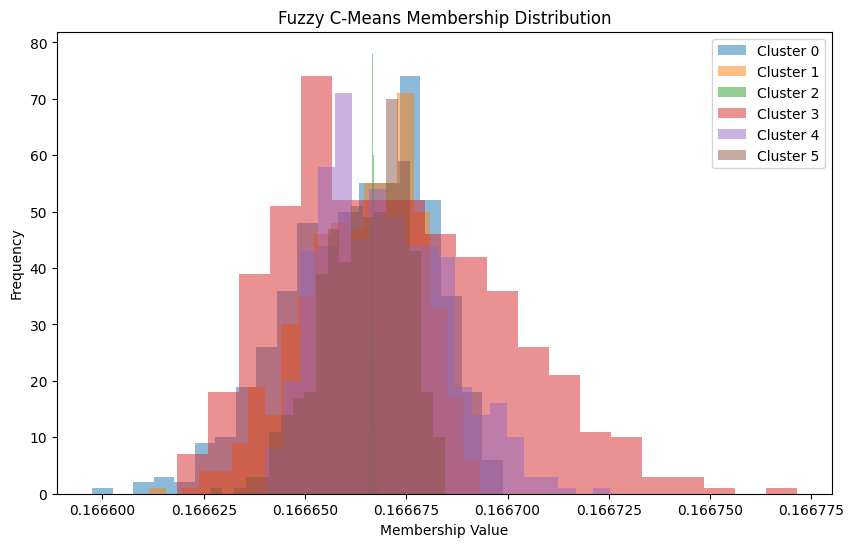

In [26]:
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.hist(u[i], bins=20, alpha=0.5, label=f'Cluster {i}')

plt.title('Fuzzy C-Means Membership Distribution')
plt.xlabel('Membership Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<h3>Extracting more keywords<h3>

In [26]:
df = pd.read_excel('data/mitre-classified.xlsx')

def change_label(df):
    stride_mapping = { # STRIDE
        1: 1, # E
        10: 2, # D
        100: 3, # I
        1000: 4, # R
        10000: 5, # T
        100000: 0, # S
        11000: 4,
        100100: 0
    }
    df['STRIDE'] = df['STRIDE'].map(stride_mapping)

while True:
    df_train, temp = train_test_split(df, test_size=0.3)
    df_test, df_dev = train_test_split(temp, test_size=1/3)

    change_label(df_train)
    change_label(df_test)
    change_label(df_dev)

    c = set([0, 1, 2, 3, 4, 5])
    if set(df_train['STRIDE'].unique()) != c or \
        set(df_test['STRIDE'].unique()) != c or \
        set(df_dev['STRIDE'].unique()) != c:
            continue
    else:
        break
    
col_toDrop = ['Ref', 'Name', 'Desc', 'Confidentiality', 'Integrity', 'Availability', 'Ease Of Exploitation', 'References', 'Unnamed: 0']
df_train = df_train.reset_index(drop=True).drop(columns=col_toDrop)
df_test = df_test.reset_index(drop=True).drop(columns=col_toDrop)
df_dev = df_dev.reset_index(drop=True).drop(columns=col_toDrop)

display(df_train.head(1))
print(f"df_train:\n{df_train['STRIDE'].value_counts()}\n")
print(f"df_dev:\n{df_dev['STRIDE'].value_counts()}\n")
print(f"df_test:\n{df_test['STRIDE'].value_counts()}")
# print((df_train.iloc[0]['NameDesc']))

,NameDesc,STRIDE
0,"Startup Items Adversaries may use startup items automatically executed at boot initialization to establish persistence. Startup items execute during the final phase of the boot process and contain shell scripts or other executable files along with configuration information used by the system to determine the execution order for all startup items.(Citation: Startup Items)<br><br>This is technically a deprecated technology (superseded by [Launch Daemon](https://attack.mitre.org/techniques/T1543/004)), and thus the appropriate folder, <code>/Library/StartupItems</code> isn't guaranteed to exist on the system by default, but does appear to exist by default on macOS Sierra. A startup item is a directory whose executable and configuration property list (plist), <code>StartupParameters.plist</code>, reside in the top-level directory. <br><br>An adversary can create the appropriate folders/files in the StartupItems directory to register their own persistence mechanism.(Citation: Methods of Mac Malware Persistence) Additionally, since StartupItems run during the bootup phase of macOS, they will run as the elevated root user.<br><br>The <code>/Library/StartupItems</code> folder can be monitored for changes. Similarly, the programs that are actually executed from this mechanism should be checked against a whitelist.<br><br>Monitor processes that are executed during the bootup process to check for unusual or unknown applications and behavior.",1


df_train:
STRIDE
1    149
3    108
5     45
0     27
2      8
4      2
Name: count, dtype: int64

df_dev:
STRIDE
1    21
3    15
5     8
0     2
4     2
2     1
Name: count, dtype: int64

df_test:
STRIDE
1    46
3    30
5    13
0     5
2     2
4     1
Name: count, dtype: int64


In [27]:
text_preprocessing(df_train)
text_preprocessing(df_test)
text_preprocessing(df_dev)

Bef rm duplicates: 147
Aft rm duplicates: 81
Removed duplicates:
 0                                                                                                                                                                                                                                [final, register, top, executable, an, execution, sierra, check, additionally, startupparameters, thus, appropriate, phase, application, initialization, a, whose, script, technically, startupitems, items, default, mechanism, technology, bootup, process, boot, folder, shell, this, guaranteed, automatically, item, user, macos, property, create, launch, the, list, since, exist, reside, information, unknown, behavior, use, order, deprecate, appear, file, elevate, startup, persistence, whitelist, configuration, determine, monitor, library, program, run, similarly, plist, unusual, execute, supersede, directory, root, establish, change, level, daemon, along, checked, actually, contain]
1                    

,NameDesc,STRIDE
0,"[group, preferences, number, associate, path, disable, delete, default, transfer, ingress, policy, move, usually, search, use, machine, delegate, secedit, include, intend, backdoor, several, modify, tools, gt, container, tool, access, account, allows, a, accompany, monitoring, gpos, write, microsoft, active, setting, many, it, leveraged, logons, object, automate, file, available, sysvol, network, service, inf, great, within, new, computer, for, execution, lt, centralize, subtle, br, scheduledtasks, gpo, right, assignment, id, store, permission, modification, user, example, create, event, privilege, since, behavior, complete, escalate, task, able, possible, potential, value, domain, malicious, gpoimmediatetask, directory, like, policies, specific, read, also, windows, discretionary, often, subsequent, seenabledelegationprivilege, job, control, set, undeleted, ...]",1
1,"[purchasing, twitter, persona, could, fill, hijack, online, variety, force, phishing, gathering, development, via, personas, spearphishing, require, utilizing, use, adversary, medium, interest, knowledge, initial, victim, site, etc, include, e, across, try, additional, modify, engineering, reuse, access, profile, connect, cultivate, conduct, account, dump, target, single, a, monitoring, engender, develop, organization, direct, suspicious, leveraged, linkedin, trust, network, service, activity, decision, level, stage, new, compromise, for, credential, operation, relationship, phase, affiliate, reconnaissance, accounts, claim, media, social, create, information, effort, utilization, potential, rather, related, compromised, lifecycle, ex, breach, photo, recently, request, facebook, detection, third, password, connection, party, others, exist, prior, important, make, method, these, focus, ...]",0
2,"[powersploit, module, tool, also, access, security, credential, execution, necessary, account, configure, attempt, dump, material, memory, host, powershell, feature, invoke, script, local, variety, mimikatz, process, analysis, secrets, collect, store, remote, lsa, policy, like, hkey, functionality, indicative, line, require, registry, extract, exist, information, operating, secret, use, machine, different, reg, command, dumped, service, log, monitor, program, argument, authority, built, incorporate, system, additional, contain]",5
3,"[software, developer, signing, tool, also, sample, security, know, self, corrupt, provide, operation, executables, associate, target, unsigned, feature, alter, script, issue, craft, install, name, detection, users, consider, process, piece, tamper, algorithm, develop, pattern, organization, code, period, authenticity, follow, much, repository, guarantee, create, thumbprint, sign, place, malware, difficult, even, digitally, outside, analyze, behavior, use, prior, adversary, make, effort, take, trust, related, certificate, common, author, certificates, confirm, identify, visibility, focus, program, activity, validity, additional, root, level]",5
4,"[group, sub, various, mitigation, windows, interpreter, payload, for, child, execution, security, wsl, without, linux, indirect, perform, control, associate, host, bypass, window, invoke, exe, script, feature, possibly, detection, allow, mechanism, abuse, process, utility, restriction, connection, component, extension, defense, policy, example, prevent, usage, event, via, line, creation, commonly, assistant, analyze, use, spawn, file, command, parameter, network, well, include, log, monitor, evasion, base, program, run, pcalua, forfiles, scripting, arbitrary, malicious, sysmon, execute, specifically, subvert, limit, result, cmd, compatibility]",1
5,"[escalation, insert, find, runtime, security, could, check, instruction, path, hijack, enables, product, correlate, individual, this, address, move, l, the, compare, search, past, use, weak, loader, other, objective, victim, apis, identify, etc, include, gain, binary, link, try, modify, scanner, access, know, location, additionally, a

In [28]:
def total_word_occurrence(df):
    all_tokens = []
    for tokens in df['NameDesc']:
        for token in tokens:
            all_tokens.append(token)
    token_count = Counter(all_tokens)
    return token_count

print(f"Total word occurrence in df_train: \n{total_word_occurrence(df_train)}")

Total word occurrence in df_train: 
Counter({'use': 314, 'also': 224, 'monitor': 196, 'process': 187, 'activity': 186, 'access': 184, 'network': 183, 'user': 177, 'command': 169, 'data': 163, 'behavior': 160, 'file': 157, 'malicious': 154, 'information': 146, 'include': 138, 'suspicious': 133, 'windows': 132, 'the': 131, 'adversary': 128, 'control': 127, 'service': 126, 'could': 125, 'execute': 123, 'within': 118, 'detection': 116, 'application': 113, 'target': 112, 'execution': 110, 'environment': 110, 'detect': 108, 'well': 106, 'line': 106, 'tool': 104, 'this': 103, 'technique': 102, 'compromise': 101, 'event': 101, 'attempt': 100, 'via': 99, 'make': 99, 'take': 98, 'log': 97, 'know': 94, 'software': 94, 'remote': 93, 'perform': 92, 'example': 91, 'base': 89, 'action': 88, 'create': 85, 'server': 85, 'specific': 85, 'in': 85, 'associate': 84, 'api': 84, 'ex': 83, 'system': 83, 'difficult': 82, 'monitoring': 81, 'run': 80, 'account': 80, 'abuse': 79, 'resource': 78, 'related': 78, 'c

In [29]:
def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')

    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)

        token_counts_by_group[stride_value] = token_count

    return token_counts_by_group

token_counts_by_group = word_occurrence_by_group(df_train)
for stride_value, token_count in token_counts_by_group.items():
    print(f"Word Occurrences for STRIDE '{stride_value}':")
    print(token_count)
    print()

Word Occurrences for STRIDE '0':
Counter({'use': 24, 'also': 18, 'target': 16, 'activity': 16, 'information': 16, 'take': 16, 'place': 16, 'detection': 16, 'include': 15, 'control': 15, 'adversary': 14, 'malicious': 14, 'ex': 14, 'behavior': 14, 'make': 14, 'access': 13, 'related': 13, 'compromise': 13, 'organization': 13, 'outside': 13, 'effort': 13, 'focus': 13, 'well': 12, 'user': 12, 'associate': 12, 'know': 12, 'data': 12, 'name': 12, 'search': 11, 'victim': 11, 'establish': 11, 'difficult': 11, 'process': 10, 'phishing': 10, 'web': 10, 'resource': 10, 'network': 10, 'service': 10, 'visibility': 10, 'could': 9, 'via': 9, 'monitor': 9, 'command': 9, 'traffic': 9, 'potentially': 9, 'suspicious': 9, 'detail': 9, 'lifecycle': 9, 'set': 9, 'infrastructure': 9, 'high': 9, 'the': 9, 'trust': 9, 'in': 9, 'e': 8, 'common': 8, 'execution': 8, 'create': 8, 'execute': 8, 'initial': 8, 'site': 8, 'location': 8, 'email': 8, 'form': 8, 'content': 8, 'if': 8, 'file': 8, 'c': 8, 'windows': 8, 'sta

<h4>Manually filter out words<h4>

STRIDE MAPPING:
0: S
5: T
4: R
3: I
2: D
1: E

In [21]:
tfidf_vectorizer = TfidfVectorizer()

df_train['NameDesc'] = df_train['NameDesc'].apply(lambda x: ' '.join(x))
df_test['NameDesc'] = df_test['NameDesc'].apply(lambda x: ' '.join(x))
df_dev['NameDesc'] = df_dev['NameDesc'].apply(lambda x: ' '.join(x))

X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['NameDesc']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(df_test['NameDesc']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(df_dev['NameDesc']).toarray()

y_train = df_train['STRIDE'].values
y_test = df_test['STRIDE'].values
y_val = df_dev['STRIDE'].values

In [91]:
# hyperparameter tuning
# num_epochs = 50
# num_classes = 6
# vocab_size = X_train_tfidf.shape[1]
# dropout_rates = [0.2, 0.3, 0.4, 0.5]
# activations_list = ['relu', 'leaky_relu', 'elu', 'tanh']
# num_neurons = [32, 64, 128, 256]
# opt_lr = [1e-2, 1e-3, 1e-4]
# L2_lr = [1e-2, 1e-3, 1e-4]
# best_params = None
# best_val_acc = 0

# hyperparam_combi = itertools.product(dropout_rates, num_neurons, activations_list, opt_lr, L2_lr)

# for dr, nn, al, olr, l2lr in hyperparam_combi:
#     modelTest = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(vocab_size,)),
#     tf.keras.layers.Dense(nn*2, activation=al),
#     tf.keras.layers.Dropout(dr),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(nn, activation=al),
#     tf.keras.layers.Dropout(dr),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(nn//2, activation=al),
#     tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2), activation='softmax')
#     ])

#     optimizer = tf.keras.optimizers.legacy.Adam(olr)
#     modelTest.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
#     early_stop = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         verbose=0,
#         restore_best_weights=True
#     )
#     histTest = modelTest.fit(
#         X_train_tfidf, y_train,
#         batch_size=16,
#         epochs=num_epochs,
#         validation_data=(X_val_tfidf, y_val),
#         verbose=0,
#         callbacks=[early_stop,]
#     )

#     val_acc = max(histTest.history['val_accuracy'])
#     # print(f"Dropout: {dr}, Activation: {al}, Hidden Units: {nn}, L2 Reg: {l2lr}, LR: {olr}, Best Val Acc: {val_acc}\n===========================")
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_params = (dr, nn, al, olr, l2lr)
# print(f"Final Best Hyperparameters: Dropout: {best_params[0]},\nActivation: {best_params[2]},\nHidden Units: {best_params[1]},\nL2 Reg: {best_params[4]},\nLR: {best_params[3]},\nBest Val Acc: {best_val_acc}")

In [92]:
hidden_units = 32
batch_size = 16
num_epochs = 50
num_classes = 6
classes = [0,1,2,3,4,5]
vocab_size = X_train_tfidf.shape[1]
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(vocab_size,)),
    tf.keras.layers.Dense(hidden_units*2, activation='elu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(hidden_units, activation='elu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(hidden_units//2, activation='elu'),
    tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2), activation='softmax')
])

model4.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model4.summary()
# plot_model(model4, show_shapes=True, show_layer_names=True)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 64)                241152    
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_54 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_109 (Dense)           (None, 32)                2080      
                                                                 
 dropout_55 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_55 (Ba  (None, 32)                128       
 tchNormalization)                                   

In [93]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def plot_graph(hist, model, X_val_padded, y_val, classes):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')


    y_pred = np.argmax(model.predict(X_val_padded), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [94]:
hist4 = model4.fit(
    X_train_tfidf, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_tfidf, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

Epoch 1/50


22/22 [==============================] - 0s 6ms/step - loss: 2.4829 - accuracy: 0.1357 - val_loss: 1.8520 - val_accuracy: 0.2857
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 2.3511 - accuracy: 0.1416 - val_loss: 1.8207 - val_accuracy: 0.3469
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 2.2712 - accuracy: 0.1504 - val_loss: 1.7938 - val_accuracy: 0.4694
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 2.1896 - accuracy: 0.1711 - val_loss: 1.7760 - val_accuracy: 0.5306
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 2.1503 - accuracy: 0.1976 - val_loss: 1.7525 - val_accuracy: 0.5306
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 2.0374 - accuracy: 0.2271 - val_loss: 1.7295 - val_accuracy: 0.5306
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 1.9397 - accuracy: 0.2596 - val_loss: 1.7101 - val_accuracy: 0.5510
Epoch 8/50
22/22 [=============

4/4 [==============================] - 0s 764us/step


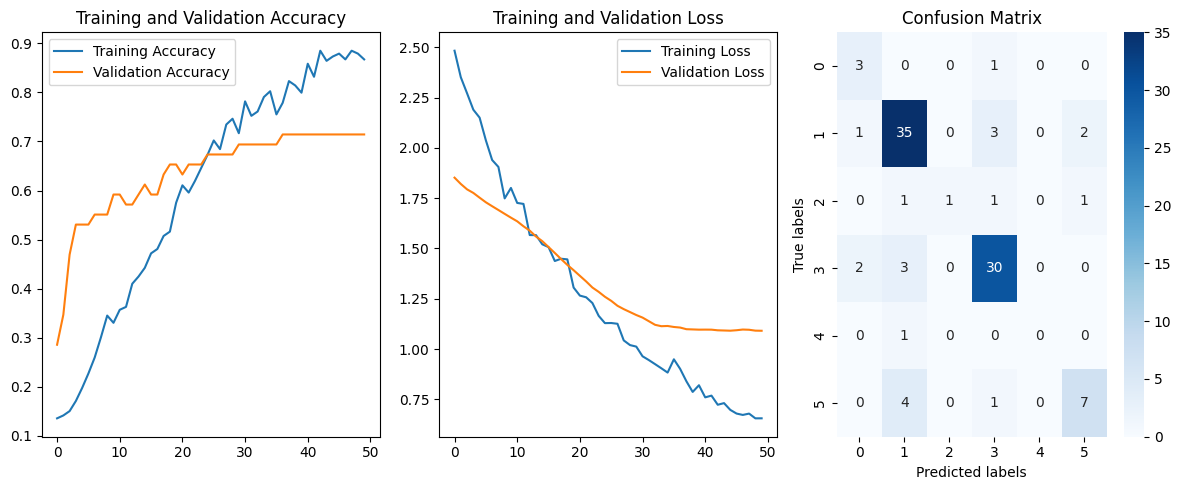

In [95]:
plot_graph(
    hist=hist4,
    model=model4,
    X_val_padded=X_test_tfidf,
    y_val=y_test,
    classes=classes
)